<a href="https://colab.research.google.com/github/apachaii/apachaii-IIC3633-2020/blob/master/06_Implicit_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    407      0 --:--:-- --:--:-- --:--:--   406
100 1546k  100 1546k    0     0   987k      0  0:00:01  0:00:01 --:--:--  107M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    706      0 --:--:-- --:--:-- --:--:--   706
100  385k  100  385k    0     0   178k      0  0:00:02  0:00:02 --:--:--  957k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    652      0 --:--:-- --:--:-- --:--:--   651
100  230k  100  230k    0     0   145k      0  0:00:01  0:00:01 --:--:--  112M


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 6.0MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419474 sha256=ad9585c413d47b28d03b5133078aa68cd8eb8ad73cb72ada7c188d036d23638a
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:**
Minimiza dos funciones de "pérdida" de manera alternante. Primero usa la matriz del usuario como una fija y hace la optimización con el gradiente con la matriz de items y luego hace el reverso 

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                        Contact (1997)
256     When the Cats Away (Chacun cherche son chat) (...
273                                           Heat (1995)
754                                     Red Corner (1997)
292                                       Rosewood (1997)
1012                                 Private Parts (1997)
409                                           Jack (1996)
125                                     Phenomenon (1996)
257                                   Men in Black (1997)
1045                                      Fearless (1993)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06457772625128401
ndcg: 0.3430321592649311


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.


In [19]:

maprecs = []
ndcgs = []
por = 0
for it in [50, 100, 200]:
  for fa in [50, 100, 200, 400]:
    # Definimos y entrenamos el modelo con optimización ALS
    model_als = implicit.als.AlternatingLeastSquares(factors=fa, iterations=it, use_gpu=False)
    model_als.fit(matrix)
    maprec, ndcg = evaluate_model(model_als, n=10)
    maprecs.append(maprec)
    ndcgs.append(ndcg)
    por += 100/12
    print(por, "%", fa, it)


8.333333333333334 % 50 50



16.666666666666668 % 100 50



25.0 % 200 50



33.333333333333336 % 400 50



41.66666666666667 % 50 100



50.00000000000001 % 100 100



58.33333333333334 % 200 100



66.66666666666667 % 400 100



75.0 % 50 200



83.33333333333333 % 100 200



91.66666666666666 % 200 200



99.99999999999999 % 400 200


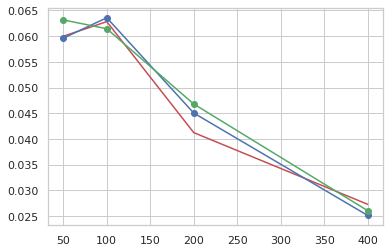

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# MAPREC
plt.plot([50, 100, 200, 400], maprecs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], maprecs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], maprecs[8:], 'go-', label = "200 factores")
plt.show()

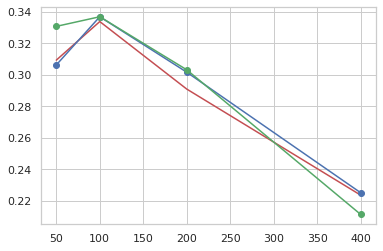

In [22]:
# NDCG
plt.plot([50, 100, 200, 400], ndcgs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], ndcgs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], ndcgs[8:], 'go-', label = "200 factores")
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.
 
 utiliza pares de de items para poder tener rankings más personalizados para los usuario

In [23]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [24]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
285                             Secrets & Lies (1996)
332                             Kiss the Girls (1997)
299                                    Hoodlum (1997)
312    Midnight in the Garden of Good and Evil (1997)
327                                   Cop Land (1997)
267                                           unknown
306       Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
676                              Crucible, The (1996)
746                                Real Genius (1985)
Name: title, dtype: object

In [25]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                              Delicatessen (1991)
209                        This Is Spinal Tap (1984)
194                                Sting, The (1973)
143                       Sound of Music, The (1965)
95                                    Aladdin (1992)
682           I Know What You Did Last Summer (1997)
264                                     Mimic (1997)
227    Star Trek VI: The Undiscovered Country (1991)
81                       Hudsucker Proxy, The (1994)
172                  Empire Strikes Back, The (1980)
Name: title, dtype: object

In [26]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.049454101099900005
ndcg: 0.327718223583461


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [27]:

maprecs = []
ndcgs = []
por = 0
for it in [50, 100, 200]:
  for fa in [50, 100, 200, 400]:
    # Definimos y entrenamos el modelo con optimización ALS
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=fa, iterations=it, use_gpu=False)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    maprecs.append(maprec)
    ndcgs.append(ndcg)
    por += 100/12
    print(por, "%", fa, it)


8.333333333333334 % 50 50



16.666666666666668 % 100 50



25.0 % 200 50



33.333333333333336 % 400 50



41.66666666666667 % 50 100



50.00000000000001 % 100 100



58.33333333333334 % 200 100



66.66666666666667 % 400 100



75.0 % 50 200



83.33333333333333 % 100 200



91.66666666666666 % 200 200



99.99999999999999 % 400 200


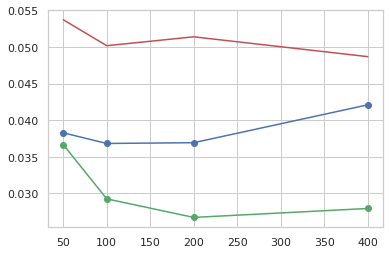

In [29]:

# MAPREC
plt.plot([50, 100, 200, 400], maprecs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], maprecs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], maprecs[8:], 'go-', label = "200 factores")
plt.show()

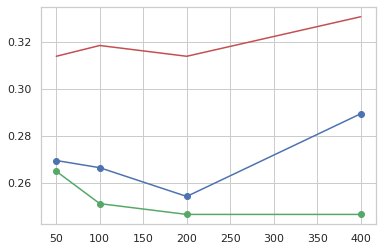

In [30]:

# NDCG
plt.plot([50, 100, 200, 400], ndcgs[:4], 'r-', label = "50 factores")
plt.plot([50, 100, 200, 400], ndcgs[4:8], 'bo-', label = "100 factores")
plt.plot([50, 100, 200, 400], ndcgs[8:], 'go-', label = "200 factores")
plt.show()